<a href="https://colab.research.google.com/github/nitrogenlab/GP15_watermassanalysis/blob/main/ocimandompa/GP15OCIMandOMPA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook first uses fluxes from a pre-defined OCIM (Ocean Circulation Inverse Model) to explain the composition of each gridbox in the ocean corresponding to the GP15 cruise transect in terms of the fractional contributions from user-defined `end-members'. These results are then used to refine the solution produced by pyompa (a software for conducting OMP analysis) to choose an OMP solution that most resembles the OCIM solution while maintaining residuals comparable to the best OMP solution.

This notebook was written by Avanti Shrikumar (avanti@cs.stanford.edu) in the Casciotti lab at Stanford (https://nitrogen.stanford.edu/)

# Use OCIM to perform water mass analysis for the GP15 transect

Our goal will be to explain observations gathered from the GP15 cruise in terms of user-specified end-members using the fluxes from OCIM2.

## Install and import needed software


### Install miniconda

Clear the pythonpath

In [ ]:
%env PYTHONPATH=

env: PYTHONPATH=


Set up a miniconda environment so we can install umfpack and metis. I followed  instructions from https://towardsdatascience.com/conda-google-colab-75f7c867a522. I had to modify the instructions above to download a python 3.7 version of miniconda as the python version in google colab changed since the post was written.


In [ ]:
%%bash
MINICONDA_INSTALLER_SCRIPT=Miniconda3-py37_4.10.3-Linux-x86_64.sh
MINICONDA_PREFIX=/usr/local
[[ -e $MINICONDA_INSTALLER_SCRIPT ]] || wget https://repo.continuum.io/miniconda/$MINICONDA_INSTALLER_SCRIPT -O $MINICONDA_INSTALLER_SCRIPT
chmod +x $MINICONDA_INSTALLER_SCRIPT
./$MINICONDA_INSTALLER_SCRIPT -b -f -p $MINICONDA_PREFIX

PREFIX=/usr/local
Unpacking payload ...
Solving environment: ...working... done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - _openmp_mutex==4.5=1_gnu
    - brotlipy==0.7.0=py37h27cfd23_1003
    - ca-certificates==2021.7.5=h06a4308_1
    - certifi==2021.5.30=py37h06a4308_0
    - cffi==1.14.6=py37h400218f_0
    - chardet==4.0.0=py37h06a4308_1003
    - conda-package-handling==1.7.3=py37h27cfd23_1
    - conda==4.10.3=py37h06a4308_0
    - cryptography==3.4.7=py37hd23ed53_0
    - idna==2.10=pyhd3eb1b0_0
    - ld_impl_linux-64==2.35.1=h7274673_9
    - libffi==3.3=he6710b0_2
    - libgcc-ng==9.3.0=h5101ec6_17
    - libgomp==9.3.0=h5101ec6_17
    - libstdcxx-ng==9.3.0=hd4cf53a_17
    - ncurses==6.2=he6710b0_1
    - openssl==1.1.1k=h27cfd23_0
    - pip==21.1.3=py37h06a4308_0
    - pycosat==0.6.3=py37h27cfd23_0
    - pycparser==2.20=py_2
    - pyopenssl==20.0.1=pyhd3eb1b0_1
    - pysocks==1.7.1=py37_1
    - python==3.7.10=h1

Update conda

In [ ]:
%%bash
conda install --channel defaults conda python=3.7 --yes
conda update --channel defaults --all --yes

Solving environment: ...working... done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - conda
    - python=3.7


The following packages will be UPDATED:

  ca-certificates                       2021.7.5-h06a4308_1 --> 2021.10.26-h06a4308_2
  certifi                          2021.5.30-py37h06a4308_0 --> 2021.10.8-py37h06a4308_0
  openssl                                 1.1.1k-h27cfd23_0 --> 1.1.1l-h7f8727e_0
  python                                  3.7.10-h12debd9_4 --> 3.7.11-h12debd9_0


Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done
Solving environment: ...working... done

## Package Plan ##

  environment location: /usr/local


The following packages will be REMOVED:

  chardet-4.0.0-py37h06a4308_1003
  gmp-6.2.1-h58526e2_0
  libblas-3.9.0-11_linux64_openblas
  libcblas-3.9.0-11_linux64_openblas
  libgfortran-ng-11.2.0-h69a702a_11
  libgfortran5-11.2.0-h5c6108e_11


Add the conda install directory to the path

In [ ]:
import sys
sys.path.append("/usr/local/lib/python3.7/site-packages")

### Install packages

Install scikit-umfpack for faster solutions of sparse linear systems

In [ ]:
! conda install -c conda-forge scikit-umfpack --yes

Solving environment: | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - scikit-umfpack


The following NEW packages will be INSTALLED:

  gmp                conda-forge/linux-64::gmp-6.2.1-h58526e2_0
  libblas            conda-forge/linux-64::libblas-3.9.0-11_linux64_openblas
  libcblas           conda-forge/linux-64::libcblas-3.9.0-11_linux64_openblas
  libgfortran-ng     conda-forge/linux-64::libgfortran-ng-11.2.0-h69a702a_11
  libgfortran5       conda-forge/linux-64::libgfortran5-11.2.0-h5c6108e_11
  liblapack          conda-forge/linux-64::liblapack-3.9.0-11_linux64_openblas
  libopenblas        conda-forge/linux-64::libopenblas-0.3.17-pthreads_h8fe5266_1
  metis              conda-forge/linux-64::metis-5.1.0-h58526e2_1006
  mpfr               conda-forge/linux-64::mpfr-4.1.0-h9202a9a_1
  numpy              conda-forge/linux-64::numpy-1.20.3-

Install METIS for better row-ordering during matrix factorization (greatly reduces memory usage)

In [ ]:
! conda install -c anaconda metis --yes

Solving environment: - \ | / - done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - metis


The following packages will be SUPERSEDED by a higher-priority channel:

  ca-certificates    conda-forge::ca-certificates-2021.10.~ --> anaconda::ca-certificates-2020.10.14-0
  certifi            conda-forge::certifi-2021.10.8-py37h8~ --> anaconda::certifi-2020.6.20-py37_0
  metis              conda-forge::metis-5.1.0-h58526e2_1006 --> anaconda::metis-5.1.0-hf484d3e_4


Preparing transaction: | done
Verifying transaction: - done
Executing transaction: | done


Install pyompa for conducting OMP analysis (pyompa was developed by the Casciotti lab and supports several capabilities beyond traditional OMP analysis)

In [ ]:
!pip uninstall -y pyompa
%cd /content/
!rm -rf pyompa
!git clone https://github.com/nitrogenlab/pyompa
%cd /content/pyompa
!git checkout dev #install from the dev branch
!git log -1
!pip install .
%cd /content/

Found existing installation: pyompa 0.4.0.0
Uninstalling pyompa-0.4.0.0:
  Successfully uninstalled pyompa-0.4.0.0
/content
Cloning into 'pyompa'...
remote: Enumerating objects: 1210, done.
remote: Counting objects: 100% (518/518), done.
remote: Compressing objects: 100% (345/345), done.
remote: Total 1210 (delta 364), reused 301 (delta 170), pack-reused 692
Receiving objects: 100% (1210/1210), 14.91 MiB | 19.94 MiB/s, done.
Resolving deltas: 100% (850/850), done.
/content/pyompa
Branch 'dev' set up to track remote branch 'dev' from 'origin'.
Switched to a new branch 'dev'
commit cabd3aa993b852d35d5b62a61de98a428221d0d8 (HEAD -> dev, origin/dev)
Author: Av Shrikumar <avanti.shrikumar@gmail.com>
Date:   Mon Nov 29 10:20:49 2021 -0800

    Update README.md
Processing /content/pyompa
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with 

Install and load the gp15wma module, which has configuration settings for the GP15 OMP analysis as well as other handy functions for loading the data

In [ ]:
!pip uninstall -y gp15wma
%cd /content/
!rm -rf gp15wmascripts
!git clone https://github.com/nitrogenlab/gp15wmascripts
%cd /content/gp15wmascripts
!git log -1
!pip install .
%cd /content/

Found existing installation: gp15wma 0.1.0.0
Uninstalling gp15wma-0.1.0.0:
  Successfully uninstalled gp15wma-0.1.0.0
/content
Cloning into 'gp15wmascripts'...
remote: Enumerating objects: 97, done.
remote: Counting objects: 100% (97/97), done.
remote: Compressing objects: 100% (71/71), done.
remote: Total 97 (delta 52), reused 65 (delta 25), pack-reused 0
Unpacking objects: 100% (97/97), done.
/content/gp15wmascripts
commit d7d1c8a2143b6f656e3001be7096a7dcf3fd763a (HEAD -> main, origin/main, origin/HEAD)
Author: Av Shrikumar <avanti.shrikumar@gmail.com>
Date:   Sun Dec 5 20:03:02 2021 -0600

    removed redundant code, updated settings
Processing /content/gp15wmascripts
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can

### Import all the relevant modules

In [ ]:
import numpy as np
import netCDF4
from matplotlib import pyplot as plt
import gsw
import pandas
from collections import OrderedDict, namedtuple
from datetime import datetime
import json
import gc
import scipy.io
import scipy.sparse
import scipy.sparse.linalg
from scipy.sparse.linalg import LinearOperator
from scipy.sparse import (isspmatrix_csc, isspmatrix_csr, isspmatrix,
                          SparseEfficiencyWarning, csc_matrix, csr_matrix)
from scipy.sparse.sputils import is_pydata_spmatrix
import scikits.umfpack as umfpack
import copy
import pyompa
import gp15wma

## Load the OCIM data

### Download the OCIM data

OCIM data are from https://figshare.com/articles/dataset/OCIM2-48L_base_state_model_output/14802732

In [ ]:
#Only try to download if the tgz file doesn't exist
![[ -e OCIM2_48L_base.tar.gz ]] || wget https://figshare.com/ndownloader/files/28468077 -O OCIM2_48L_base.tar.gz
#Unzip the files
!tar -xzf OCIM2_48L_base.tar.gz

### Load the transport matrix

We load the original transport matrix

In [ ]:
base_transport = scipy.io.loadmat("OCIM2_48L_base_transport.mat")['TR']

### Load other relevant base data

Load latitude, longitude and depth co-ordinates for gridboxes from OCIM2_48L_base_data.nc.

In [ ]:
data = netCDF4.Dataset("OCIM2_48L_base_data.nc")
#ocnmask is a mask indicating whether a grid cell is in the ocean
# the ocean grid cells correspond to the entries in the transport matrix
ocnmask = data.variables['ocnmask'][:].data==1.0
#ulat, ulon and wz are the lat/lon/depth coordinates corresponding to the fluxes
ulat = data.variables['ulon'][:].data #latlon are swapped in the nc file
ulon = data.variables['ulat'][:].data #latlon are swapped in the nc file
wz = data.variables['wz'][:].data

As a sanity check, let's do a scatterplot of all the lat/lon coordinates corresponding to the ocean gridpoints. We note that the OCIM longitude co-ordinates go fro 0 to 360.

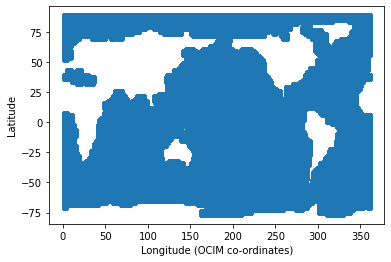

In [ ]:
plt.scatter(ulon[ocnmask], ulat[ocnmask])
plt.xlabel("Longitude (OCIM co-ordinates)")
plt.ylabel("Latitude")
plt.show()

Get the latitude, longitude and depth specifically at ocean gridboxes. Also convert longitudes to have negative values west of the prime meridian, consistent with more standard notation.

In [ ]:
#the _ocnvec suffix indicates the vector of properties corresponds to grid
# boxes that are in the ocean; it lines up with the axes of the transport matrix
ulat_ocnvec = ulat.ravel()[ocnmask.ravel()]
ulon_ocnvec = ulon.ravel()[ocnmask.ravel()]
#convert ulon to have negative longitudes to the west of the prime meridian,
# which makes it more compatible with what other packages expect
ulon_ocnvec = (ulon_ocnvec*(ulon_ocnvec <= 180)
               + (-(360-ulon_ocnvec)*(ulon_ocnvec > 180)))

depth_ocnvec = wz.ravel()[ocnmask.ravel()]

As a sanity check, we'll make sure that the converted longitude coordinates correspond to what we want (i.e. negative values west of the prime meridian)

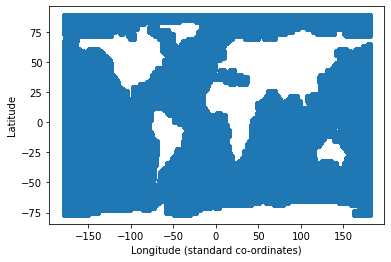

In [ ]:
plt.scatter(ulon_ocnvec, ulat_ocnvec)
plt.xlabel("Longitude (standard co-ordinates)")
plt.ylabel("Latitude")
plt.show()

## Load the World Ocean Atlas data

### Download the WOA data

Key for reading the WOA data:
- s=salinity, t=temperature, i=silicate, o=oxygen  
- _an is the objectively analyzed value   
- decav is the decadal average  
- A5B7 is 2005 to 2017  (A=2000s, B=2010s). "All" indicates all time ranges. "all" is only available for nutrients and is not available for temp/salinity
- The 00 in s00/t00/i00/o00 indicates it's an annual value  
- 1.00 indicates it's for a 1-degree-resolution grid, as does the 01 suffix in the file name

In [ ]:
#WOA18 for A5B7 salinity
! [[ -e woa18_A5B7_s00_01.nc ]] || wget https://www.ncei.noaa.gov/data/oceans/woa/WOA18/DATA/salinity/netcdf/A5B7/1.00/woa18_A5B7_s00_01.nc -O woa18_A5B7_s00_01.nc

#WOA18 A5B7 temperature
! [[ -e woa18_A5B7_t00_01.nc ]] || wget https://www.ncei.noaa.gov/data/oceans/woa/WOA18/DATA/temperature/netcdf/A5B7/1.00/woa18_A5B7_t00_01.nc -O woa18_A5B7_t00_01.nc

#WOA18 "all" silicate
! [[ -e woa18_all_i00_01.nc ]] || wget https://www.ncei.noaa.gov/data/oceans/woa/WOA18/DATA/silicate/netcdf/all/1.00/woa18_all_i00_01.nc -O woa18_all_i00_01.nc

#WOA18 "all" oxygen
! [[ -e woa18_all_o00_01.nc ]] || wget https://www.ncei.noaa.gov/data/oceans/woa/WOA18/DATA/oxygen/netcdf/all/1.00/woa18_all_o00_01.nc -O woa18_all_o00_01.nc


### Load WOA into a pandas data frame

In [ ]:
def extract_woa_into_df(attr_to_woancdata):
    attributes = list(attr_to_woancdata.keys())
    lat_ticks = attr_to_woancdata[attributes[0]]['lat'][:].data
    lon_ticks = attr_to_woancdata[attributes[0]]['lon'][:].data
    depth_ticks = attr_to_woancdata[attributes[0]]['depth'][:].data
    #make sure the ticks are the same across all woancdata entries, as a
    # sanity check
    for attr in attr_to_woancdata:
        assert tuple(lat_ticks) == tuple(attr_to_woancdata[attr]['lat'][:].data)
        assert tuple(lon_ticks) == tuple(attr_to_woancdata[attr]['lon'][:].data)
        assert tuple(depth_ticks) == tuple(
                                       attr_to_woancdata[attr]['depth'][:].data)

    attr_to_data = dict([(attr, attr_to_woancdata[attr][attr][:].data)
                         for attr in attr_to_woancdata])
    attr_to_nanfill = dict([(attr, attr_to_woancdata[attr][attr]._FillValue)
                          for attr in attr_to_woancdata])

    pandas_dict = OrderedDict([
        ('depth', []),
        ('latitude', []),
        ('longitude', [])
    ])
    for attr in attr_to_woancdata:
        pandas_dict[attr] = []

    for depthidx in range(len(depth_ticks)):
        for latidx in range(len(lat_ticks)):
            for lonidx in range(len(lon_ticks)):
                #only consider points where data is present
                # for some of the readings
                data_present = any([(
                    attr_to_data[attr][0, depthidx, latidx, lonidx]
                    != attr_to_nanfill[attr]) for attr in attributes])
                if (data_present):
                    pandas_dict['depth'].append(depth_ticks[depthidx])
                    pandas_dict['latitude'].append(lat_ticks[latidx])
                    pandas_dict['longitude'].append(lon_ticks[lonidx])
                    for attr in attr_to_data:
                        dataval =\
                            attr_to_data[attr][0, depthidx, latidx, lonidx]
                        if (dataval == attr_to_nanfill[attr]):
                            dataval = np.nan
                        pandas_dict[attr].append(dataval)
    return pandas.DataFrame(pandas_dict)

woa18_df = extract_woa_into_df(
              attr_to_woancdata={
                  't_an': netCDF4.Dataset("woa18_A5B7_t00_01.nc"),
                  's_an': netCDF4.Dataset("woa18_A5B7_s00_01.nc"),
                  'i_an': netCDF4.Dataset("woa18_all_i00_01.nc"),
                  'o_an': netCDF4.Dataset("woa18_all_o00_01.nc")
                  })

Add conservative temperature, absolute salinity and potential density to the WOA data frame

In [ ]:
def augment_woa_with_conservative_vals(woa_df):
    depth = np.array(woa_df["depth"])
    lats = np.array(woa_df["latitude"])
    lons = np.array(woa_df["longitude"])
    #pressure calculation from depth
    p = gsw.p_from_z(
      z=-depth, #z is expected to be negative in the ocean
      lat=lats)
    #get the absolute salinity given the practical salinity and pressure
    abssal = gsw.SA_from_SP(SP=np.array(woa_df["s_an"]), #practical salinity
                            p=p, lon=lons, lat=lats)
    #get conservative temp given absolute salinity, temp and pressure
    ctemp = gsw.CT_from_t(SA=abssal,
                          t=np.array(woa_df["t_an"]), #temperature
                          p=p)
    #get sigma2/sigma2/sigma4, which will be used for defining the locations of
    # endmembers
    sig0 = gsw.sigma0(SA=abssal, CT=ctemp)
    sig2 = gsw.sigma2(SA=abssal, CT=ctemp)
    sig4 = gsw.sigma4(SA=abssal, CT=ctemp)
    
    woa_df["pressure"] = p
    woa_df["absolute_salinity"] = abssal
    woa_df["conservative_temperature"] = ctemp
    woa_df["sigma0"] = sig0
    woa_df["sigma2"] = sig2
    woa_df["sigma4"] = sig4

augment_woa_with_conservative_vals(woa_df=woa18_df)

### Index WOA data by OCIM gridboxes

We organize the measurements into a data structure such that we can easily retrieve the measurements corresponding to particular OCIM gridboxes

First, we get the depth, latitude and longitude 'axes tickmarks' corresponding to the OCIM gridboxes

In [ ]:
ocim_wz_ticks = tuple(wz[:,0,0])
ocim_ulat_ticks = tuple(ulat[0,0,:])
ocim_ulon_ticks = tuple(ulon[0,:,0])

#also delete obsolete variables
del data
del ulat
del ulon
del wz
gc.collect()

5163

Next, we define functions that can be used for mapping the measured data into a data structure corresponding to the OCIM gridboxes. Each observation is assigned to the OCIM gridbox that has the closest value of ulat/ulon/depth.

In [ ]:
#This function initializes an empty grid
def initialize_grid(shape):
    grid = []
    for depth_idx in range(shape[0]):
        grid_depthentry = []
        for lon_idx in range(shape[1]):
            grid_lonentry = []
            for lat_idx in range(shape[2]):
                grid_latentry = []
                grid_lonentry.append(grid_latentry)
            grid_depthentry.append(grid_lonentry)
        grid.append(grid_depthentry)
    return grid

#This function maps observations in a data frame into a grid
def prepare_obsgrid_from_df(df, wz_ticks, ulon_ticks, ulat_ticks,
                                depth_key, longitude_key, latitude_key,
                                keys_to_record):
    obs_grid = initialize_grid((len(wz_ticks), len(ulon_ticks), len(ulat_ticks)))
    
    ObsEntry = namedtuple('ObsEntry', keys_to_record)
    
    df_lats = np.array(df[latitude_key])
    df_lons = np.array(df[longitude_key])
    df_depths = np.array(df[depth_key])

    #np.searchsorted gives the insertion index in order
    # to maintain sort order
    #Also need to convert the lons to the 0-360 system used by OCIM
    df_lons_converted = (df_lons*(df_lons >= 0.0)
                         + (df_lons + 360)*(df_lons < 0.0))
    lat_insert_idxs = np.searchsorted(a=ulat_ticks, v=df_lats)
    lon_insert_idxs = np.searchsorted(a=ulon_ticks, v=df_lons_converted)
    depth_insert_idxs = np.searchsorted(a=wz_ticks, v=df_depths)

    #also get the contents associated with keys_to_record, to avoid
    # storing unnecessarily large amounts of data
    key_to_coldata = dict([
        (key, np.array(df[key])) for key in keys_to_record
    ])

    for i in range(len(lat_insert_idxs)):
        lat_insert_idx = lat_insert_idxs[i]
        lon_insert_idx = lon_insert_idxs[i]
        depth_insert_idx = depth_insert_idxs[i]

        item_lat = df_lats[i]
        item_lon = df_lons_converted[i]
        item_depth = df_depths[i]

        #In an Arakawa-B grid, the velocities are measured in the center of
        # the grid. Thus, we want to map the observation to the gridbox
        # for which the lat/lon/depth measurement is closer.
        lat_idx = (lat_insert_idx
              if (abs(ulat_ticks[lat_insert_idx] - item_lat)
                  < abs(ulat_ticks[lat_insert_idx-1] - item_lat))
              else lat_insert_idx-1)
        #Need to do the %360 to account for wrap-around
        lon_idx = (lon_insert_idx
                  if (abs(ulon_ticks[lon_insert_idx] - item_lon)%360
                      < abs(ulon_ticks[lon_insert_idx-1] - item_lon)%360)
                   else lon_insert_idx-1)
        #If the insertion index is deeper than the tick of the deepest gridbox,
        # the index is the one corresponding to the deepest gridbox (0-indexed)
        if (depth_insert_idx == len(wz_ticks)):
            depth_idx = depth_insert_idx - 1
        else:
            depth_idx = (depth_insert_idx
                        if (abs(wz_ticks[depth_insert_idx] - item_depth)
                            < abs(wz_ticks[depth_insert_idx-1] - item_depth))
                        else depth_insert_idx-1)
        obs_grid[depth_idx][lon_idx][lat_idx].append(
            ObsEntry(*[key_to_coldata[key][i] for key in keys_to_record ] ))
    
    return obs_grid

Now we run those functions to map the WOA data into gridboxes

In [ ]:
woa18_obs_grid = prepare_obsgrid_from_df(df=woa18_df,
    wz_ticks=ocim_wz_ticks, ulon_ticks=ocim_ulon_ticks,
    ulat_ticks=ocim_ulat_ticks,
    depth_key="depth", longitude_key="longitude", latitude_key="latitude",
    keys_to_record=["conservative_temperature", "absolute_salinity",
                    "i_an", "o_an", "sigma0", "sigma2", "sigma4"])

### Compute average WOA data in OCIM gridboxes

Compute things like the average silicate concentration, average conservative temperature of the WOA data in each OCIM gridbox.

In [ ]:
#Function that averages the observations in each gridbox,
# returning np.nan when there are no observations in a gridbox
def get_data_from_obs_grid(func, obs_grid):
    to_return = np.zeros(
        (len(obs_grid), len(obs_grid[0]),
         len(obs_grid[0][0])) )
    to_return[:,:,:] = np.nan
    for i in range(len(obs_grid)):
        for j in range(len(obs_grid[i])):
            for k in range(len(obs_grid[i][j])):
                if len(obs_grid[i][j][k]) > 0:
                    to_return[i,j,k] = func(obs_grid[i][j][k])
    return to_return

def get_mean_from_obs_grid(attr, obs_grid):
    return get_data_from_obs_grid(
              func=eval("lambda arr: np.mean([y."+attr+" for y in arr])"),
              obs_grid=obs_grid)

#Get the mean conservative temperature, absolute salinity,
# and silicate in the ocean gridboxes with WOA18 data
woa18_mean_ctemp_ocnvec = get_mean_from_obs_grid(
    attr="conservative_temperature",
    obs_grid=woa18_obs_grid).ravel()[ocnmask.ravel()]
woa18_mean_abssal_ocnvec = get_mean_from_obs_grid(
    attr="absolute_salinity",
    obs_grid=woa18_obs_grid).ravel()[ocnmask.ravel()]
woa18_mean_silicate_ocnvec = get_mean_from_obs_grid(
    attr="i_an",
    obs_grid=woa18_obs_grid).ravel()[ocnmask.ravel()]

#also get the potential density and oxygen data as this will be
# useful for defining end-member boundaries
woa18_mean_sig0_ocnvec = get_mean_from_obs_grid(
    attr="sigma0",
    obs_grid=woa18_obs_grid).ravel()[ocnmask.ravel()]
woa18_mean_sig2_ocnvec = get_mean_from_obs_grid(
    attr="sigma2",
    obs_grid=woa18_obs_grid).ravel()[ocnmask.ravel()]
woa18_mean_sig4_ocnvec = get_mean_from_obs_grid(
    attr="sigma4",
    obs_grid=woa18_obs_grid).ravel()[ocnmask.ravel()]
woa18_mean_oxygen_ocnvec = get_mean_from_obs_grid(
    attr="o_an",
    obs_grid=woa18_obs_grid).ravel()[ocnmask.ravel()]

Save memory by deleting the objects corresponding to `woa18_obs_grid` and `woa18_df`

In [ ]:
del woa18_obs_grid
del woa18_df

gc.collect()

50

## Idenitify OCIM gridboxes corresponding to end-members

We define endmembers by lat/lon/potential density and figure out the indexes in the vector of ocean gridboxes that correspond to each endmember. We also use WOA data to add in a filter on oxygen.

In [ ]:
#Function to get the indexes that match a lat/lon/potential density threshold
# range. These are indexes into the vector of ocean gridboxes.
def get_endmember_idxs(lat_min, lat_max,
                      lon_min, lon_max,
                      invert_lon=False,
                      depth_min=0, depth_max=np.inf,
                      sig0_min=0, sig0_max=np.inf, 
                      sig2_min=0, sig2_max=np.inf,
                      sig4_min=0, sig4_max=np.inf,
                      ox_min=0, ox_max=np.inf):    
    nonzero_idxs = np.nonzero(
      (ulat_ocnvec >= lat_min)*(ulat_ocnvec <= lat_max)
     *((((ulon_ocnvec) >= lon_min)*((ulon_ocnvec) <= lon_max))
       ==(False if invert_lon else True))
     *(depth_ocnvec >= depth_min)*(depth_ocnvec <= depth_max)
     *(woa18_mean_sig0_ocnvec >= sig0_min)*(woa18_mean_sig0_ocnvec <= sig0_max)
     *(woa18_mean_sig2_ocnvec >= sig2_min)*(woa18_mean_sig2_ocnvec <= sig2_max)
     *(woa18_mean_sig4_ocnvec >= sig4_min)*(woa18_mean_sig4_ocnvec <= sig4_max)
     *(woa18_mean_oxygen_ocnvec >= ox_min)
     *(woa18_mean_oxygen_ocnvec <= ox_max)
    )[0]    
    return nonzero_idxs

endmember_definitions = {
    "AAIW": {"lat_min":-55.0, "lat_max":-43.0,
             "lon_min":-90, "lon_max":-80,
             "sig0_min":27.05, "sig0_max":27.15},
    "NPIW": {"lat_min":36.5, "lat_max":39.0, 
             "lon_min":148.0, "lon_max":154.0, 
             "sig0_min":26.4, "sig0_max":26.9},
    "UCDW": {"lat_min":-49.5, "lat_max":-44.5, 
             "lon_min":-157.0, "lon_max":-147.0,
             "sig0_min":27.35, "sig0_max":27.75},
    "LCDW": {"lat_min":-66.5, "lat_max":-61.5, 
             "lon_min":-100.0, "lon_max":150.0,
             "invert_lon":True,
             "sig0_min":27.79, "sig0_max":27.83},
    "AABW": {"lat_min":-66.5, "lat_max":-61.5, 
             "lon_min":-100.0, "lon_max":150.0,
             "invert_lon":True,
             "sig4_min":46.04, "sig4_max":200,
             "depth_min":1500},
    "PDW": {"lat_min":39.0, "lat_max":51.0, 
             "lon_min":-170.0, "lon_max":-133.0,
             "sig0_min":27.2, "sig0_max":200,
             "sig4_min":0, "sig4_max":45.88},
    "EqIW": {"lat_min":-5, "lat_max":5, 
             "lon_min":-90.0, "lon_max":-80.0,
             "sig0_min": 26.86, "sig0_max": 27.3},
    "PSUW": {"lat_min":50, "lat_max":58, 
             "lon_min":-155, "lon_max":-140,
             "sig0_min": 25.29, "sig0_max": 26.5},
    "ENPCW": {"lat_min":16, "lat_max":26, 
             "lon_min":-170, "lon_max":-140,
             "sig0_min": 25.29, "sig0_max": 26.5},
    "ESSW": {"lat_min":-5, "lat_max":5, 
             "lon_min":-90.0, "lon_max":-80.0,
             "sig0_min": 25.29, "sig0_max": 26.86},
    "SPCW": {"lat_min":-30, "lat_max":-20, 
             "lon_min":-152, "lon_max":-130, 
             "sig0_min": 25.29, "sig0_max": 26.86},
}

endmem_to_idxs = dict([(the_key, set(get_endmember_idxs(**val)))
                        for the_key,val in endmember_definitions.items()])

Delete variables that are no-longer needed

In [ ]:
del woa18_mean_sig0_ocnvec
del woa18_mean_sig2_ocnvec
del woa18_mean_sig4_ocnvec
del woa18_mean_oxygen_ocnvec

gc.collect()

77

As a sanity check, we can visualize the locations on the map for each endmember

AABW


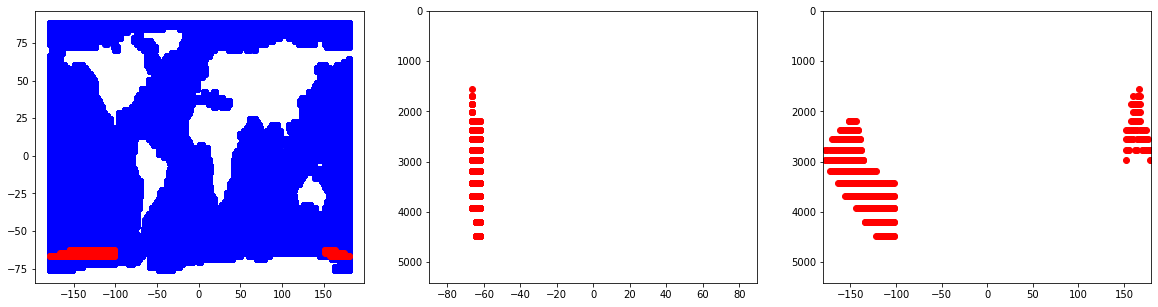

AAIW


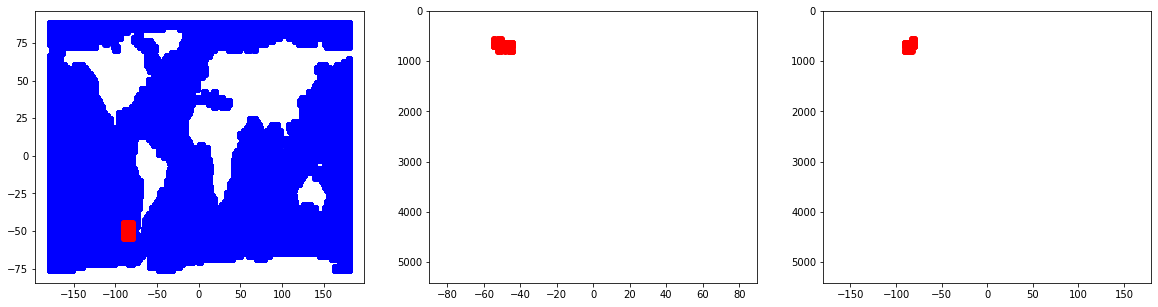

ENPCW


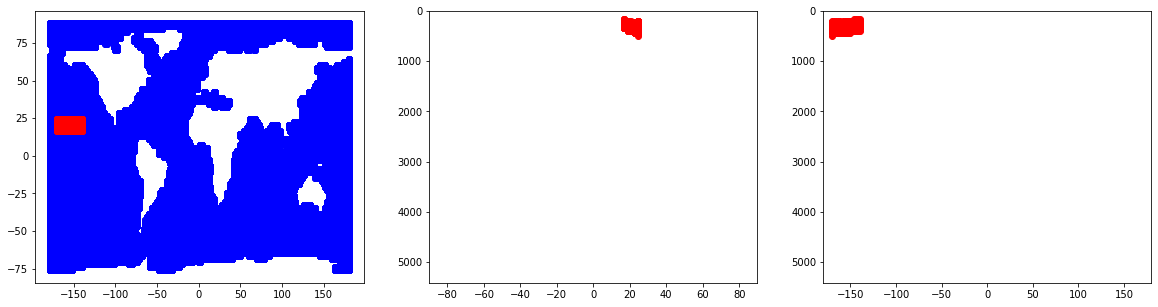

ESSW


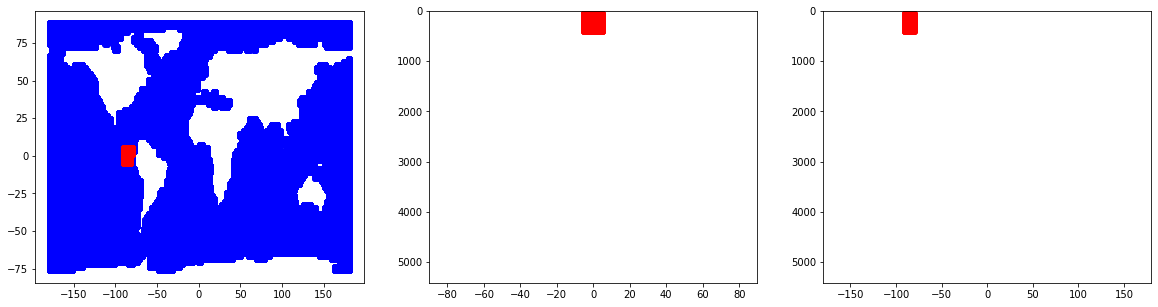

EqIW


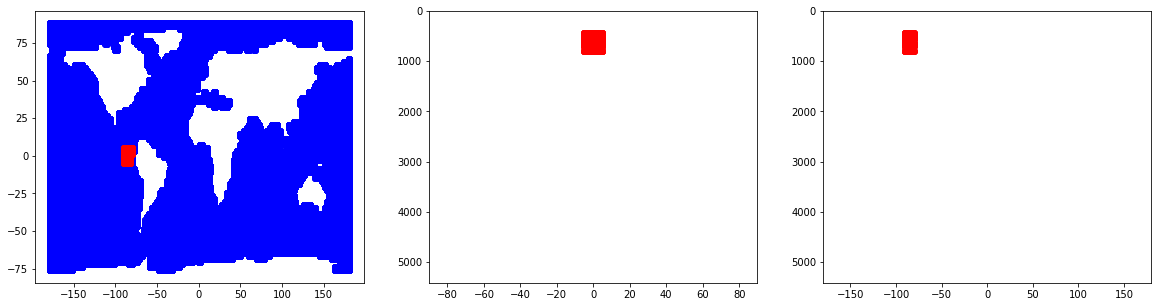

LCDW


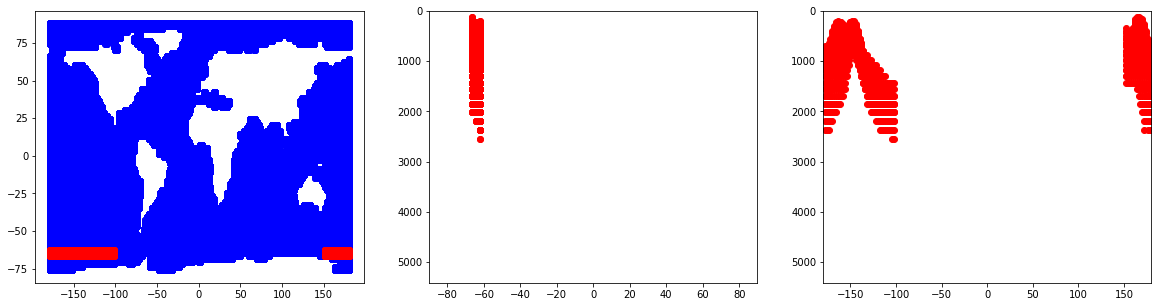

NPIW


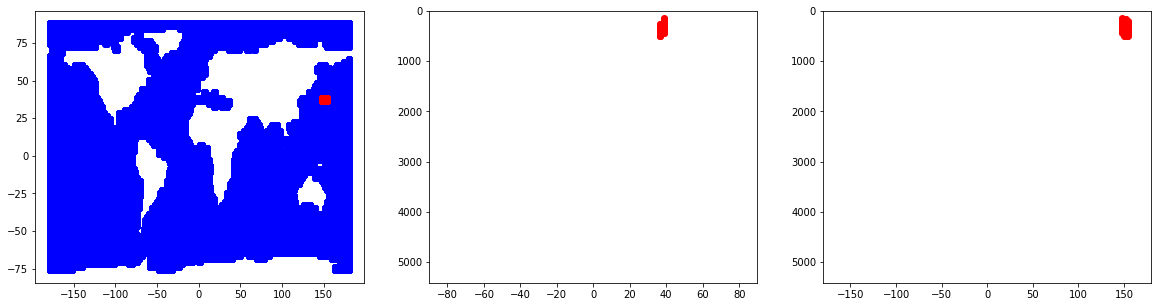

PDW


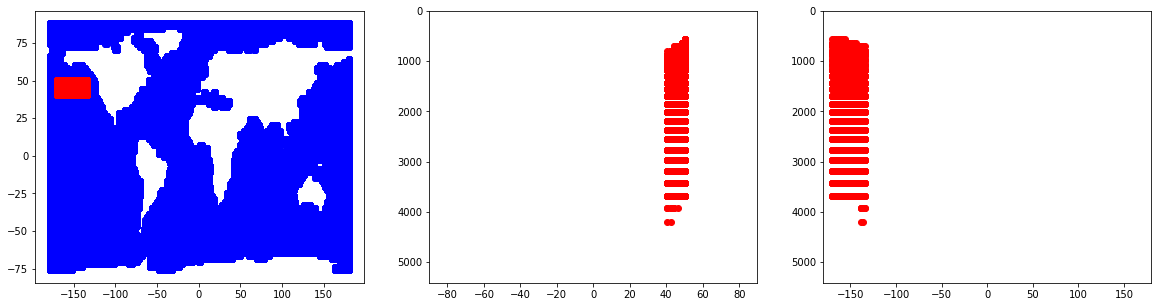

PSUW


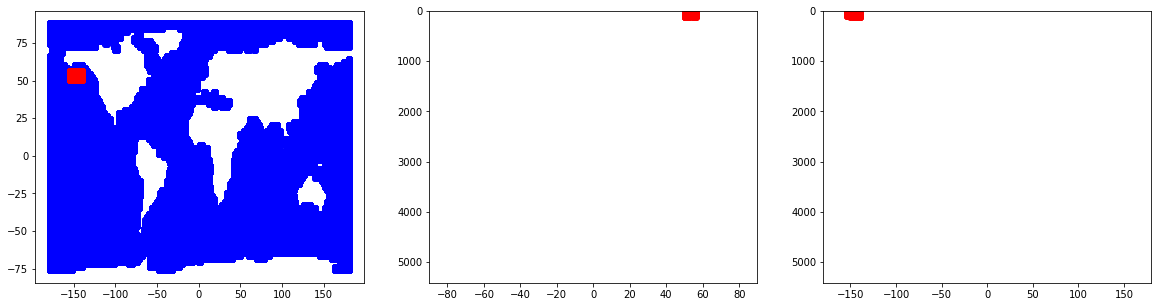

SPCW


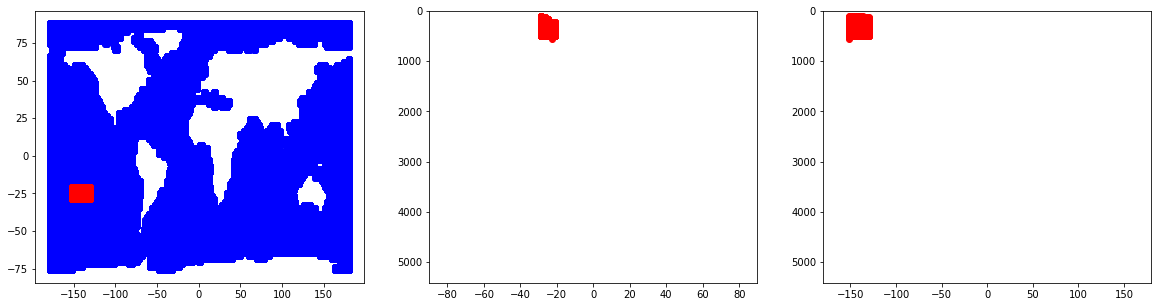

UCDW


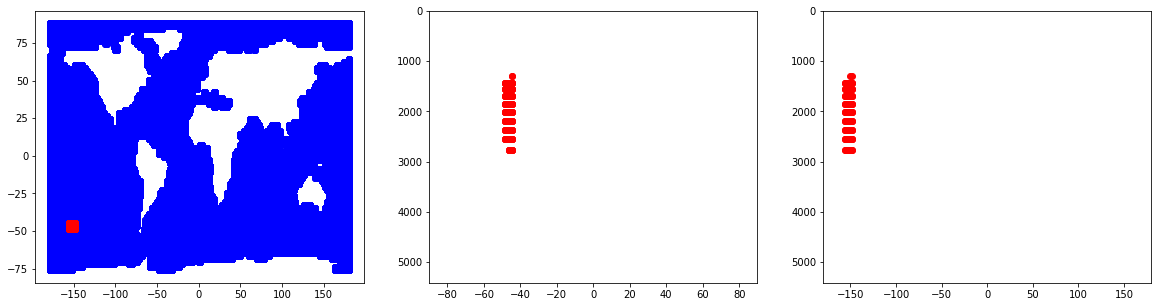

In [ ]:
endmem_names = sorted(endmem_to_idxs.keys())

for endmem in endmem_names:
    print(endmem)
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,5))

    plt.sca(ax[0])
    #first make a scatterplot of the water surface
    plt.scatter(ulon_ocnvec,
            ulat_ocnvec, color="blue")
    #now overlay the endmember
    #handles.append(
    plt.scatter(
        ulon_ocnvec[np.array(list(endmem_to_idxs[endmem]))],
        ulat_ocnvec[np.array(list(endmem_to_idxs[endmem]))],
        color="red")
    #)

    plt.sca(ax[1])
    plt.scatter(
        ulat_ocnvec[np.array(list(endmem_to_idxs[endmem]))],
        depth_ocnvec[np.array(list(endmem_to_idxs[endmem]))],
        color="red")
    plt.xlim(-90,90)
    plt.ylim(max(depth_ocnvec),0)

    plt.sca(ax[2])
    plt.scatter(
        ulon_ocnvec[np.array(list(endmem_to_idxs[endmem]))],
        depth_ocnvec[np.array(list(endmem_to_idxs[endmem]))],
        color="red")
    plt.xlim(-180,180)
    plt.ylim(max(depth_ocnvec),0)
    plt.show()


## Load the GP15 data

We load the GP15 data so that we can compare how the predictions from OCIM along the GP15 transect compare to the empirical measurements on the GP15 cruise. We focus on intermediate and deep waters here.

In [ ]:
gp15_df, gp15_intermediateanddeep, gp15_thermocline = gp15wma.download_and_load_gp15_data(
    station_to_tc_cutoffs_url="https://raw.githubusercontent.com/nitrogenlab/GP15_watermassanalysis/main/station_to_tc_cutoffs.json")
del gp15_df, gp15_thermocline

bottle flag BTLNBR_FLAG_W BTLNBR_FLAG_W
uint8
leg1 nans 0
leg2 nans 0
CTD salinity flag CTDSAL_FLAG_W CTDSAL_FLAG_W
uint8
leg1 nans 0
leg2 nans 0
bottle oxygen flag Flag_OXYGEN_D_CONC_BOTTLE_qizf9x Flag_OXYGEN_D_CONC_BOTTLE_n41f8b
uint8
leg1 nans 0
leg2 nans 0
silicate flag Flag_SILICATE_D_CONC_BOTTLE_l9fh07 Flag_SILICATE_D_CONC_BOTTLE_3fot83
uint8
leg1 nans 0
leg2 nans 0
nitrate flag Flag_NITRATE_D_CONC_BOTTLE_xhgtuv Flag_NITRATE_D_CONC_BOTTLE_bugat8
uint8
leg1 nans 0
leg2 nans 0
phosphate flag Flag_PHOSPHATE_D_CONC_BOTTLE_lof4ap Flag_PHOSPHATE_D_CONC_BOTTLE_d0rgav
uint8
leg1 nans 0
leg2 nans 0
CTD pressure CTDPRS CTDPRS
float64
leg1 nans 487
leg2 nans 492
CTD temperature CTDTMP CTDTMP
float64
leg1 nans 487
leg2 nans 492
practical_salinity CTDSAL CTDSAL
float64
leg1 nans 487
leg2 nans 492
lat LATITUDE LATITUDE
float64
leg1 nans 476
leg2 nans 484
lon LONGITUDE LONGITUDE
float64
leg1 nans 476
leg2 nans 484
stnnbr STNNBR STNNBR
<U12
leg1 and leg2 arrays are strings.
geotrc_ID GEOTRC_SAMP

### Index GP15 data by OCIM gridboxes

We can reuse the code from when we read the GLODAP data into OCIM gridboxes

In [ ]:
gp15_obs_grid = prepare_obsgrid_from_df(df=gp15_intermediateanddeep,
    wz_ticks=ocim_wz_ticks, ulon_ticks=ocim_ulon_ticks,
    ulat_ticks=ocim_ulat_ticks,
    depth_key="Depth", longitude_key="lon", latitude_key="lat",
    keys_to_record=["conservative_temp", "absolute_salinity", "silicate"])

### Compute average GP15 data in OCIM gridboxes

As before, we reuse the code we wrote for doing this on GLODAP data

In [ ]:
#Get the mean conservative temperature, absolute salinity and silicate
gp15_mean_ctemp_ocnvec = get_mean_from_obs_grid(
    attr="conservative_temp",
    obs_grid=gp15_obs_grid).ravel()[ocnmask.ravel()]
gp15_mean_asbsal_ocnvec = get_mean_from_obs_grid(
    attr="absolute_salinity",
    obs_grid=gp15_obs_grid).ravel()[ocnmask.ravel()]
gp15_mean_silicate_ocnvec = get_mean_from_obs_grid(
    attr="silicate",
    obs_grid=gp15_obs_grid).ravel()[ocnmask.ravel()]

Delete objects to save memory

In [ ]:
del gp15_intermediateanddeep
del gp15_obs_grid
gc.collect()

100

## Compute the distributions at steady-state

We compute the distributions of tracers and end-members at steady state, treating the end-members as sources for the rest of the ocean

### Prepare code to compute steady-state distributions

There are some bugs associated with Google Colab's version of scipy in terms of how it interfaces with umfpack. To fix this, I have ported over an alternative versions of the relevant functions from https://github.com/scipy/scipy/pull/11453.

I have also modified the functions to use the METIS ordering for the LU decomposition, since the default umfpack ordering runs out of memory without this.

In [ ]:
#see https://github.com/scipy/scipy/pull/11453

def _get_umf_family(A):
    """Get umfpack family string given the sparse matrix dtype."""
    _families = {
        (np.float64, np.int32): 'di',
        (np.complex128, np.int32): 'zi',
        (np.float64, np.int64): 'dl',
        (np.complex128, np.int64): 'zl'
    }

    f_type = np.sctypeDict[A.dtype.name]
    i_type = np.sctypeDict[A.indices.dtype.name]

    try:
        family = _families[(f_type, i_type)]

    except KeyError:
        msg = 'only float64 or complex128 matrices with int32 or int64' \
            ' indices are supported! (got: matrix: %s, indices: %s)' \
            % (f_type, i_type)
        raise ValueError(msg)

    # See gh-8278. Considered converting only if
    # A.shape[0]*A.shape[1] > np.iinfo(np.int32).max,
    # but that didn't always fix the issue.
    family = family[0] + "l"
    A_new = copy.copy(A)
    A_new.indptr = np.array(A.indptr, copy=False, dtype=np.int64)
    A_new.indices = np.array(A.indices, copy=False, dtype=np.int64)

    return family, A_new


def get_umf_context(A):
    if is_pydata_spmatrix(A):
        A = A.to_scipy_sparse().tocsc()

    if not isspmatrix_csc(A):
        A = csc_matrix(A)
        warn('splu requires CSC matrix format', SparseEfficiencyWarning)

    A = A.asfptype()  # upcast to a floating point format

    if A.dtype.char not in 'dD':
        raise ValueError("convert matrix data to double, please, using"
              " .astype(), or set linsolve.useUmfpack = False")

    umf_family, A = _get_umf_family(A)
    umf = umfpack.UmfpackContext(umf_family)
    #METIS ordering ends up taking up MUCH less memory!
    umf.control[umfpack.UMFPACK_ORDERING] = umfpack.UMFPACK_ORDERING_METIS

    #see 'alternative routines' section of the UMFPACK user guide
    # page 17 describes the orderings
    #Also see documentation for umfpackcontext:
    # https://github.com/scikit-umfpack/scikit-umfpack/blob/a2102ef92f4dd060138e72bb5d7c444f8ec49cbc/scikits/umfpack/umfpack.py#L114

    return umf, A


#creating a fixed version of factorize
def fixed_factorize(A):
    umf, A = get_umf_context(A)
    # Make LU decomposition.
    umf.numeric(A)
    def solve(b):
        return umf.solve(umfpack.UMFPACK_A, A, b, autoTranspose=True)
    return solve


#create a fixed version of solve
def fixed_solve(A, b):
    umf, A = get_umf_context(A)

    return umf.linsolve(umfpack.UMFPACK_A, A, b,
                         autoTranspose=True)

    return solve


Now we are ready to define the function to get the steady-state tracer concentrations by solving the linear system.

In [ ]:

class GetSteadyStateTracerConcsViaMatrixSolve(object):
    
    """
    T: the 2d transport matrix
    source_idxs: the set of indexes to designate as source gridboxes
    """
    def __init__(self, T, source_idxs, tau=None):
        print(datetime.now(), "Prepping solver")
        self.tau = tau
        to_factorize = self.get_tofactorize(T=T, source_idxs=source_idxs)
        #self.find_conditionnumber(mat=to_factorize)
        #Don't invert the matrix!
        # https://www.johndcook.com/blog/2010/01/19/dont-invert-that-matrix/
        self.solver = fixed_factorize(to_factorize)
        print(datetime.now(), "solver prepped")

    @staticmethod
    def find_conditionnumber(mat):
        print(datetime.now(),"Computing A A^t")
        AAt = mat @ mat.transpose()
        print(datetime.now(),"Getting largest eigenvalue")
        largest_eig = scipy.sparse.linalg.eigsh(A=AAt, k=1, which='LM',
                                                return_eigenvectors=False)
        print(datetime.now(), largest_eig)
        print(datetime.now(),"Getting smallest eigenvalue")
        smallest_eig = scipy.sparse.linalg.eigsh(A=AAt, k=1, which='SM',
                                                 sigma=0,
                                                 return_eigenvectors=False)
        print(datetime.now(), smallest_eig)
        print("Ratio:", largest_eig/smallest_eig)
        
    #source_vecs should be set to the empirically-determined concentration
    # of the tracer for the source gridboxes, and should be 0 for all
    # non-source gridboxes.
    def __call__(self, source_vecs):        
        print(datetime.now(), "Calling solver")
        if (self.tau is not None):
            return self.solver(-source_vec/self.tau)
        else:
            return self.solver(-source_vec)
        print(datetime.now(), "Solver called")
        
    def get_tofactorize(self, T, source_idxs):
        #Return the matrix that needs to be factorized
        # [(I - M)T - M] for the tau=None case
        # (T - M/tau) for the other case
        m_vec = np.zeros(T.shape[0])
        m_vec[source_idxs] = 1.0
        M = scipy.sparse.diags(m_vec)
        if (self.tau is not None):
            return csc_matrix(T - M/self.tau)
        else:
            I_minus_M = scipy.sparse.diags(1 - m_vec)
            return csc_matrix(I_minus_M@T - M)



### Instantiate the solver

Instantiate a solver that's appropriate for the source indices we are using in this case

In [ ]:
source_idxs = np.array(list(set(np.concatenate(
                  [list(x) for x in endmem_to_idxs.values()], axis=0))))

solver = GetSteadyStateTracerConcsViaMatrixSolve(
            T=base_transport,
            source_idxs=source_idxs,
            #tau=None,
            tau=(1.0/(60*60*24*365))
            )

2021-12-06 02:38:39.145313 Prepping solver
2021-12-06 02:39:13.944042 solver prepped


### Compute the steady-state tracer distributions

With the solver instantiated, we can compute the expected tracer concentrations based on the OCIM fluxes, assuming that the sources for the tracers are the defined end-members

On  absolute salinity
2021-12-06 02:39:14.028257 Calling solver
On  conservative temp
2021-12-06 02:39:15.518186 Calling solver
On  silicate
2021-12-06 02:39:16.984223 Calling solver


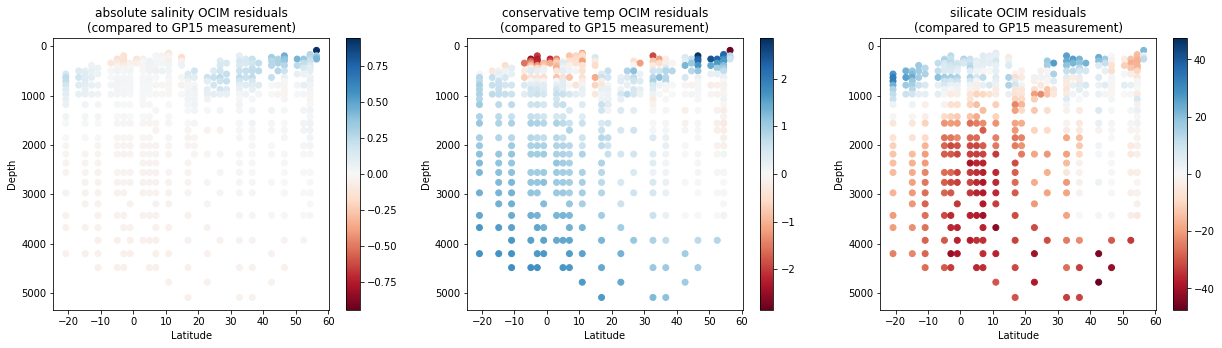

In [ ]:
tracers = [
    ("absolute salinity", woa18_mean_abssal_ocnvec, gp15_mean_asbsal_ocnvec),
    ("conservative temp", woa18_mean_ctemp_ocnvec, gp15_mean_ctemp_ocnvec),
    ("silicate", woa18_mean_silicate_ocnvec, gp15_mean_silicate_ocnvec)
]

gp15_idxs = np.nonzero((np.isnan(gp15_mean_ctemp_ocnvec)==False))

fig, ax = plt.subplots(nrows=1, ncols=len(tracers),
                       figsize=(len(tracers)*7, 5))

tracer_to_ocim_residuals = {}

for i,(tracer_name, woa18_tracer_vals, gp15_tracer_vals) in enumerate(tracers):
    print("On ",tracer_name)
    #source vec has to be zero at all entries that are not sources. At
    # source entries, it should equal the empirically measured values
    source_vec = np.zeros(base_transport.shape[0])
    source_vec[source_idxs] = woa18_tracer_vals[source_idxs]
    steady_state_soln = solver(source_vec)

    plt.sca(ax[i])
    #Compute the residual with respect to the GP15 observation
    residuals = (steady_state_soln[gp15_idxs] - gp15_tracer_vals[gp15_idxs])
    tracer_to_ocim_residuals[tracer_name] = residuals
    plt.scatter(
        ulat_ocnvec[gp15_idxs],
        depth_ocnvec[gp15_idxs],
        c=residuals,
        vmin=-np.max(np.abs(residuals)), vmax=np.max(np.abs(residuals)),
        cmap="RdBu"
    )
    plt.ylim(plt.ylim()[1], plt.ylim()[0])
    plt.ylabel("Depth")
    plt.xlabel("Latitude")
    plt.title(tracer_name+" OCIM residuals\n(compared to GP15 measurement)")
    plt.colorbar()

plt.show()

### Compute the steady-state end-member distributions

Eeach end-member is like a tracer that has a value of 1 at all source gridboxes occupied by the end-member, and a value of 0 at all source gridboxes that are not occupied by the end-member. We will also define an end-member called "_ALL" that is the union of all endmembers in order to diagnose whether we may have missing end-members (if there are no end-members missing, then the end-member fractions should sum up close to 1 everywhere)

We will plot each end-member both on a fixed 0-1 scale (bottom) and on a relative scale that is adjusted to the minimum/maximum concentration of that end-member. The latter allows us to see the end-member distribution more clearly, while the former allows us to compare results for different end-members.

On: AABW
2021-12-06 02:39:19.250329 Calling solver
Globally:
max val: 1.106662242806089
min val: -0.32361541431237145
Along GP15:
max val: 0.24193200268555937
min val: -2.172763099946829e-11
On: AAIW
2021-12-06 02:39:20.721038 Calling solver
Globally:
max val: 1.1318533092808378
min val: -0.013906422920186807
Along GP15:
max val: 0.17942581382879005
min val: -2.8994188993411887e-11
On: ENPCW
2021-12-06 02:39:22.165648 Calling solver
Globally:
max val: 1.0079248828939198
min val: -0.16118411633374102
Along GP15:
max val: 0.6439171214689285
min val: -1.215685297661533e-10
On: ESSW
2021-12-06 02:39:23.604183 Calling solver
Globally:
max val: 1.3926845882954504
min val: -0.05452924414564224
Along GP15:
max val: 0.3236916842805736
min val: -3.235559880934448e-11
On: EqIW
2021-12-06 02:39:25.039199 Calling solver
Globally:
max val: 1.026185021757575
min val: -0.38280557362339757
Along GP15:
max val: 0.5035058474261337
min val: -9.959415923683928e-11
On: LCDW
2021-12-06 02:39:26.487628 Callin

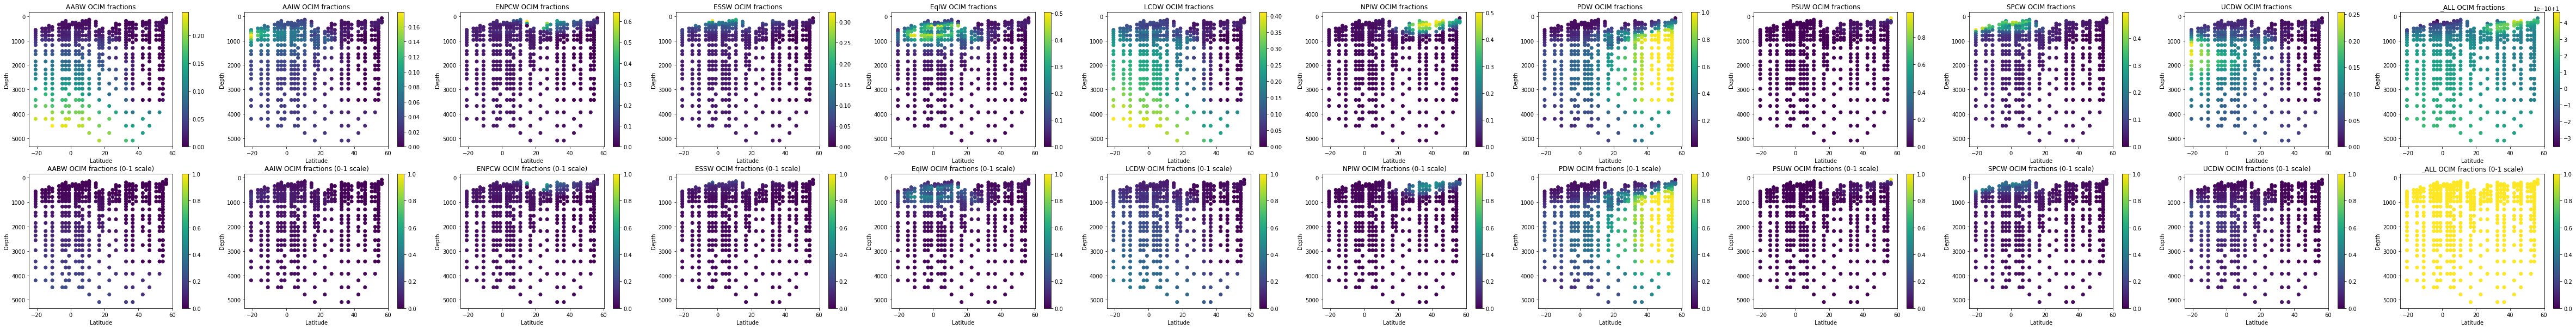

In [ ]:
#find steady-state distributions

endmem_to_idxs["_ALL"] = source_idxs

fig, ax = plt.subplots(nrows=2, ncols=len(endmem_to_idxs),
                       figsize=(len(endmem_to_idxs)*7, 10))

tracer_to_endmem_fracs = {}

for i, endmem in enumerate(sorted(endmem_to_idxs.keys())):
    print("On:", endmem)
    endmem_idxs = np.array(list(endmem_to_idxs[endmem]))
    source_vec = np.zeros(base_transport.shape[0])
    source_vec[endmem_idxs] = 1.0
    steady_state_soln = solver(source_vec)
    
    print("Globally:")
    print("max val:",np.max(steady_state_soln))
    print("min val:",np.min(steady_state_soln))
    print("Along GP15:")
    print("max val:",np.max(steady_state_soln[gp15_idxs]))
    print("min val:",np.min(steady_state_soln[gp15_idxs]))
    #If the transport matrix has no off-diagonal negative entries, then
    # numerical errors can lead to frac values less than 0 or more than 1; get
    # rid of this
    #steady_state_soln = np.maximum(0, np.minimum(steady_state_soln, 1.0))

    plt.sca(ax[0,i])
    plt.scatter(
        ulat_ocnvec[gp15_idxs],
        depth_ocnvec[gp15_idxs],
        c=steady_state_soln[gp15_idxs]
    )
    plt.ylim(plt.ylim()[1], plt.ylim()[0])
    plt.ylabel("Depth")
    plt.xlabel("Latitude")
    plt.title(endmem+" OCIM fractions")
    plt.colorbar()

    plt.sca(ax[1,i])
    plt.scatter(
        ulat_ocnvec[gp15_idxs],
        depth_ocnvec[gp15_idxs],
        c=steady_state_soln[gp15_idxs],
        vmin=0.0, vmax=1.0
    )
    plt.ylim(plt.ylim()[1], plt.ylim()[0])
    plt.ylabel("Depth")
    plt.xlabel("Latitude")
    plt.title(endmem+" OCIM fractions (0-1 scale)")
    plt.colorbar()

plt.show()

    

# Perform OMP analysis for the GP15 transect

We will use the pyompa implementation of OMP, as this has several additional features/improvements over traditional OMP analysis.

## Download and load pyompa end-member definitions

We focus on intermediate and deep waters here. We will use the gp15wma package.

In [ ]:
interanddeep_endmember_df = gp15wma.load_interanddeep_endmember_df(
    df_url="https://raw.githubusercontent.com/nitrogenlab/GP15_watermassanalysis/main/GP15_intermediateanddeep_endmemberswithsubtypes.csv",
    df_file_name="GP15_intermediateanddeep_endmemberswithsubtypes.csv")

## Run pyompa

We use the settings in the gp15wma package

In [ ]:
pyompa_soln = gp15wma.get_pyompa_soln(
    obs_df=gp15_intermediateanddeep,
    endmember_df_touse=interanddeep_endmember_df)

## Contrast pyompa residuals with OCIM residuals

In [ ]:
pyompa_soln

NameError: ignored

# Use OCIM to refine the OMPA results

Our pyompa system is underdetermined, i.e. the solution is ambiguous. We can use OCIM to select a specific solution that achieves similar residuals to the best pyompa solution and also matches the OCIM solution as closely as possible